In [1]:
import numpy as np
import pandas as pd
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
import copy
import sys
import sympy

In [2]:
def getVariableMatrices(variableNames, variableDf):
    independentVariableMat = []
    dependentVariableMat = []
    
    dependentVariable = variableNames[0]
    for variable in variableNames:
        if variable == dependentVariable:
            continue
        
        independentVariableMat.append(variableDf[variable])
        
    independentVariableMat = pd.DataFrame(independentVariableMat).to_numpy().reshape(len(variableNames)-1, len(variableDf))
    dependentVariableMat = variableDf[dependentVariable].to_numpy().reshape(len(variableDf), 1)
    
    return (dependentVariableMat, independentVariableMat)

In [3]:
def modifyVariables(modelVariables, variableDf):
    
    modifiedModelVariables = copy.deepcopy(modelVariables)
    
    for currIndex in range(len(modifiedModelVariables)):
        
        #skip the dependent variable
        if currIndex == 0:
            continue
        
        item = modifiedModelVariables[currIndex]
        variable = item[0]
        power = item[1]
        
        if power == 1:
            newVariable = variable
            modifiedModelVariables[currIndex] = newVariable            
        
        elif power > 1:
            newVariable = variable + "^" + str(power)
            variableDf[newVariable] = variableDf[variable]**power
            modifiedModelVariables[currIndex] = newVariable
            
    return modifiedModelVariables

In [4]:
def estimateBeta(dependentVariable, independentVariable, variableDf):
    
    dependentVariableMin = variableDf[dependentVariable].min()
    dependentVariableMax = variableDf[dependentVariable].max()
    
    independentVariableMin = variableDf[independentVariable].min()
    independentVariableMax = variableDf[independentVariable].max()
    correlation = variableDf[dependentVariable].corr(variableDf[independentVariable])
    
    # Naive estimation of effect of this feature on the dependent variable
    naiveEstimate = (dependentVariableMax - dependentVariableMin)/(independentVariableMax - independentVariableMin)
    if(correlation < 0):
        naiveEstimate = naiveEstimate * -1
    
    # Add some randomness to the naive estimate
    independentVariableMean = variableDf[independentVariable].mean()
    independentVariableStdDev = variableDf[independentVariable].std()
    randomVal = independentVariableMean + stats.norm.ppf(random.uniform(0, 1))*independentVariableStdDev
    
    naiveEstimate = naiveEstimate*(randomVal/independentVariableMean)
    
    return naiveEstimate

In [5]:
def estimateAlpha(betaEstimates, modelVariables, variableDf):
    
    independentVariable = modelVariables[0]
    independentVariableMean = variableDf[independentVariable].mean()
    
    estimatedAlphas = []
    for i in range(len(modelVariables)):
        variable = modelVariables[i]
        if variable == independentVariable:
            continue
        
        estimateMean = betaEstimates[i-1]*variableDf[variable].mean()
        estimatedAlpha = independentVariableMean - estimateMean
        
        
        estimatedAlphas.append(estimatedAlpha)
        
    return sum(estimatedAlphas)/len(estimatedAlphas)



# PARTICLE SWARM OPTIMIZATION

In [6]:
def getFitness(location, dependentVariableMatrix, independentVariableMatrix):
    alphaCoeff = copy.deepcopy(location[0])
    betaCoeffs = copy.deepcopy(np.array(location[1:]))

    predictions = alphaCoeff + betaCoeffs.dot(independentVariableMatrix)
    predictions = predictions.reshape(len(predictions), 1)
    
    squaredDifference = (dependentVariableMatrix - predictions)**2
    squaredDifference = squaredDifference.reshape(len(squaredDifference), 1)
    
    sumOfSquaredDifference = float(sum(squaredDifference))
    
    return 1/sumOfSquaredDifference

In [7]:
def getInitialSwarmLocation(swarmSize, modelVariables, variableDf, dependentVariableMatrix, independentVariableMatrix):
    swarmEstimatedLocations = {}
        
    dependentVariable = modelVariables[0]
    dependentVariableMin = variableDf[dependentVariable].min()
    dependentVariableMax = variableDf[dependentVariable].max()
    
    
    for particle in range(swarmSize):
        swarmEstimatedLocations[particle] = {}
        
        betaEstimates = []
        for variable in modelVariables:
            if variable == dependentVariable:
                continue
                  
            betaEstimate = estimateBeta(dependentVariable, variable, variableDf)
            
            betaEstimates.append(betaEstimate)
                    
        alphaEstimate = estimateAlpha(betaEstimates, modelVariables, variableDf)
        betaEstimates.insert(0, alphaEstimate)        
        
        swarmEstimatedLocations[particle]["Location"] = betaEstimates
        swarmEstimatedLocations[particle]["Personal Best"] = betaEstimates
        swarmEstimatedLocations[particle]["Velocity"] = np.zeros(shape = (len(betaEstimates)))
        swarmEstimatedLocations[particle]["Fitness"] = float(getFitness(betaEstimates, dependentVariableMatrix, independentVariableMatrix))
        
    return swarmEstimatedLocations

In [8]:
def getInitialGlobalBest(swarm):
    
    globalBest = {}
    
    globalBest['Fitness'] = sys.float_info.min
    
    for particle in swarm:
        personalBestFitness = swarm[particle]['Fitness']
        particleLocation = swarm[particle]['Location']
        
        if(personalBestFitness > globalBest['Fitness']):
            globalBest["Fitness"] = copy.deepcopy(personalBestFitness)
            globalBest["Location"] =  copy.deepcopy(particleLocation)
            
    return globalBest

In [9]:
def getVelocity(particle, globalBest, w, c1, c2):
    particleLocation = copy.deepcopy(particle['Location'])
    particlePersonalBest = copy.deepcopy(particle['Personal Best'])
    particleFitness = copy.deepcopy(particle['Fitness'])
    particleVelocity = copy.deepcopy(particle['Velocity'])
    
    globalBestFitness = copy.deepcopy(globalBest['Fitness'] ) 
    globalBestLocation = copy.deepcopy(globalBest['Location'])
        
    distanceToPersonalBest = np.asarray(particlePersonalBest) - np.asarray(particleLocation)
    distanceToGlobalBest = np.asarray(globalBestLocation) - np.asarray(particleLocation)
    
    newVelocity = w*particleVelocity  +  distanceToPersonalBest*random.uniform(0, 1)*c1  +  distanceToGlobalBest*random.uniform(0, 1)*c2
    
    return newVelocity 

In [10]:
def updatePersonalDetails(particle, velocity, proposedLocation, proposedLocationFitness):  
    particle['Location'] = proposedLocation
    particle['Personal Best'] = proposedLocation        
    particle['Fitness'] = proposedLocationFitness
    particle['Velocity'] = velocity



def updateGlobalDetails(particle, globalBest):
    particleLocation = copy.deepcopy(particle['Location'])
    particleFitness = copy.deepcopy(particle['Fitness'])
    globalBestFitness = copy.deepcopy(globalBest['Fitness'])
    globalBestLocation = copy.deepcopy(globalBest['Location'])
    
    if(particleFitness > globalBestFitness):
        globalBest['Location'] = particle['Location']
        globalBest['Fitness'] = particle['Fitness']     
        
        


def updateItems(particle, globalBest, w, c1, c2, dependentVariableMatrix, independentVariableMatrix):
    
    velocity = getVelocity(particle, globalBest, w, c1, c2)
    proposedLocation = particle['Location'] + velocity    
    proposedLocationFitness = getFitness(proposedLocation, dependentVariableMatrix, independentVariableMatrix)
    
    
    if (proposedLocationFitness > particle['Fitness']):
        updatePersonalDetails(particle, velocity, proposedLocation, proposedLocationFitness)
        updateGlobalDetails(particle, globalBest)   
        
    else:
        # Allow 'bad' move if the move is extremely likely with some randomness
        if (proposedLocationFitness/particle['Fitness'] > random.uniform(0, 1)):
              updatePersonalDetails(particle, velocity, proposedLocation, proposedLocationFitness)
              updateGlobalDetails(particle, globalBest)              
          
    return 


In [11]:
def allParticlesAreAtGlobalOptimum(swarm, globalBest):
    
    dimensionsInLocation = len(swarm[0]['Location'])
    
    for particle in swarm:
        if(swarm[particle]['Fitness'] == globalBest['Fitness']):
            return False
        
    return True

In [12]:
def updateParticleFitnessHistory(swarm, particleFitnessHistory):
    if len(particleFitnessHistory) == 0:
        for particle in swarm:
            particleFitnessHistory[particle] = []
            particleFitnessHistory[particle].append(1/swarm[particle]['Fitness'])
            
    else:
        for particle in swarm:
            particleFitnessHistory[particle].append(1/swarm[particle]['Fitness'])
        
    return



def updateParticleLocationHistory(swarm, particleLocationHistory, variableNames):
    if len(particleLocationHistory) == 0:
        for particle in swarm:
            particleLocationHistory[particle] = {}
            
            for i in range(len(variableNames)):
                variable = variableNames[i]
                
                particleLocationHistory[particle][variable] = []
                particleLocationHistory[particle][variable].append(swarm[particle]['Location'][i])
                
    else:
        for particle in swarm:
            for i in range(len(variableNames)):
                variable = variableNames[i]
                particleLocationHistory[particle][variable].append(swarm[particle]['Location'][i])
                
    return


def updateGlobalFitnessHistory(gBest, globalFitnessHistory):
    if len(globalFitnessHistory) == 0:
        globalFitnessHistory['SS Residuals'] = []
        globalFitnessHistory['SS Residuals'].append(1/gBest['Fitness'])
        
    else:
        globalFitnessHistory['SS Residuals'].append(1/gBest['Fitness'])
        
    return

In [13]:
modelVariables = ["CO2 emissions (kt)", ("GDP growth", 1), ("GDP growth", 2)]
variableDf = pd.read_excel("./Sample Data.xlsx")

In [14]:
def predict(modelVariables, variableDf, w, c1, c2, noOfParticles, actualSSResiduals = -1):
    variableNames = modifyVariables(modelVariables, variableDf)
    dependentVariableMatrix, independentVariableMatrix = getVariableMatrices(variableNames, variableDf)
    
    
    swarm = getInitialSwarmLocation(noOfParticles, variableNames, variableDf, dependentVariableMatrix, independentVariableMatrix)
    gBest = getInitialGlobalBest(swarm)
    
    
    globalFitnessHistory = {}
    particleFitnessHistory = {}
    particleLocationHistory = {}
    noOfIterations = 1

    while True:
        for particle in swarm:
            updateParticleFitnessHistory(swarm, particleFitnessHistory)
            updateParticleLocationHistory(swarm, particleLocationHistory, variableNames)
            updateGlobalFitnessHistory(gBest, globalFitnessHistory)
            updateItems(swarm[particle], gBest, w, c1, c2, dependentVariableMatrix, independentVariableMatrix)
            
        
        # if the Best Sum of Squared Error is Provided
        if (actualSSResiduals >= 0):
            testVal = float(1/gBest['Fitness'])/actualSSResiduals

            if (testVal <= 1.001 and testVal >= 0.999):
                break
                
        # If the Actual Sum of Squared Error is not Provided      
        if (actualSSResiduals == -1):
            if allParticlesAreAtGlobalOptimum(swarm, gBest) == True:
                break
                
        noOfIterations = noOfIterations + 1
    
    result = {}
    result["Particle Fitness History"] = particleFitnessHistory
    result['Particle Location History'] = particleLocationHistory
    result['No of Iterations'] = noOfIterations
    result['Global Fitness History'] = globalFitnessHistory
    result['Global Best Location'] = gBest['Location']
    result['Global Best Fitness'] = gBest['Fitness']
    
    return result

In [15]:
# Fitting Polynomial Regression to the dataset

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = np.array(variableDf[modelVariables[1][0]]).reshape(-1, 1)
y = np.array(variableDf[modelVariables[0]]).reshape(-1, 1)

poly = PolynomialFeatures(include_bias = True, degree = 2)
X_poly = poly.fit_transform(X)

poly.fit(X_poly, y)
lin = LinearRegression()
lin.fit(X_poly, y)

actualSolution = lin.coef_
actualSolution[0][0] = lin.intercept_
actualSolution = actualSolution[0]

In [16]:
actualSolution

array([264306.31183149,  29693.09592485,  -7001.06719004])

## Testing for the Effect of Swarm Size

In [17]:
def getNoOfIterations(modelVariables, variableDf, w, c1, c2, noOfParticles, actualSSResiduals, noOfTrials = 10):
    noOfIterations = []
    for i in range(noOfTrials):
        noOfIterations.append(predict(modelVariables, variableDf, w, c1, c2, noOfParticles, actualSSResiduals)['No of Iterations'])
 
    
    return noOfIterations

### Testing Hypotheis 1

In [18]:
noOfIterations100 = getNoOfIterations(modelVariables, variableDf, 0.5, 0.5, 0.8, 100, 4.2104e+11, 10)
noOfIterations500 = getNoOfIterations(modelVariables, variableDf, 0.5, 0.5, 0.8, 500, 4.2104e+11, 10)
noOfIterations1000 = getNoOfIterations(modelVariables, variableDf, 0.5, 0.5, 0.8, 1000, 4.2104e+11, 10)

In [19]:
noOfIterations100

[5, 3, 7, 9, 7, 4, 8, 4, 7, 6]

In [20]:
np.mean(noOfIterations100)

6.0

In [21]:
noOfIterations500

[2, 3, 3, 3, 2, 3, 2, 3, 3, 3]

In [22]:
np.mean(noOfIterations500)

2.7

In [23]:
noOfIterations1000

[2, 2, 3, 2, 2, 2, 3, 3, 2, 3]

In [24]:
np.mean(noOfIterations1000)

2.4

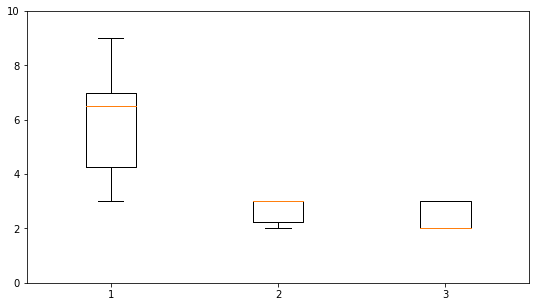

In [25]:
data = [noOfIterations100, noOfIterations500, noOfIterations1000]
fig, ax = plt.subplots(1)
ax.set_ylim(ymin=0, ymax=10)
ax.boxplot(data)

fig.set_size_inches(9, 5)
plt.show(fig)

### Testing Hypotheis 2

In [26]:
def getNoOfAccurateResults(modelVariables, variableDf, w, c1, c2, noOfParticles, actualSSResiduals, noOfTrials = 10):
    noOfAccurateResults = 0
    
    for trial in range(noOfTrials):
        globalBestFitness = predict(modelVariables, variableDf, w, c1, c2, noOfParticles)['Global Best Fitness']
    
        testVal = float(1/globalBestFitness)/actualSSResiduals
        if (testVal <= 1.001 and testVal >= 0.999):
            noOfAccurateResults = noOfAccurateResults + 1
            
    return noOfAccurateResults
    